In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from os import path
from sklearn import discriminant_analysis

In [2]:
_HOME_ = path.expanduser("~") + "/PHD"

In [3]:
cluster_indices = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Unknown_effect/cluster_indices.xlsx", sheet_name="method_2", index_col=[0,1])

In [4]:
env_long = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data_cleaned_long_format.csv", index_col=[3, 2]).drop("Unnamed: 0", axis=1)
env_long.index = pd.MultiIndex.from_tuples([(pd.to_datetime(date),id) for date, id in env_long.index], names=["Date", "id"])

In [5]:
features = [
    "T", 
    "Salinity", 
    "O_sat", 
    "pH", 
    "Chla", 
    "NO3", 
    "NO2", 
    "NH4", 
    "TN", 
    "PO4", 
    "TP", 
    "SiO4"
]

<Axes: >

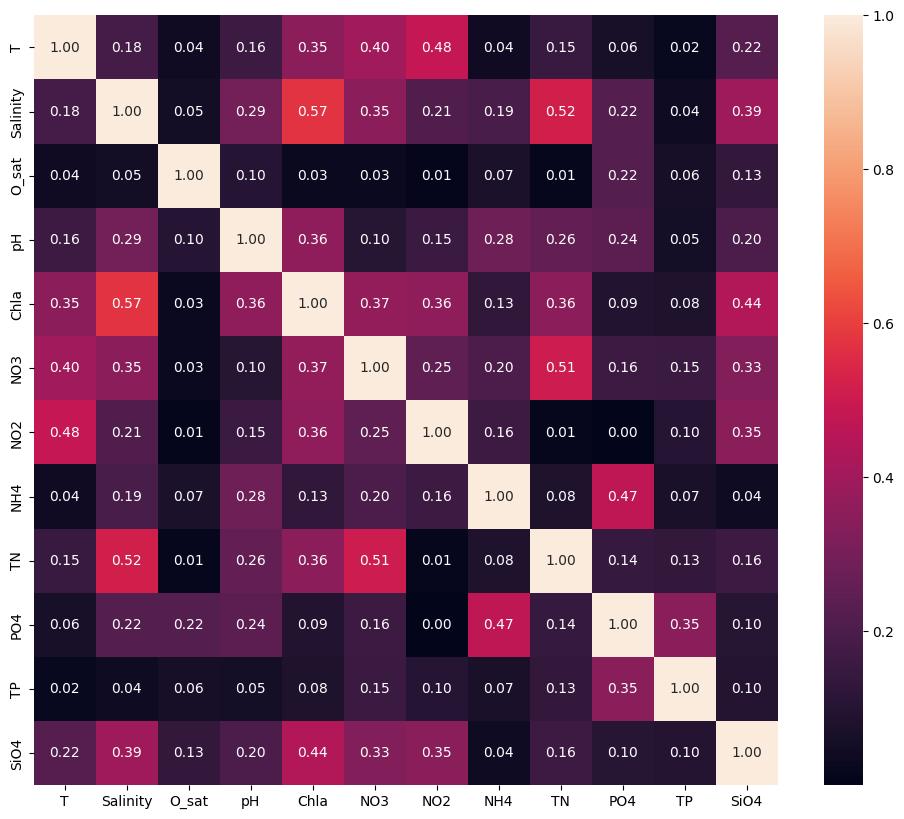

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(
    np.abs(env_long.loc[:, features].corr("spearman")), 
    annot=True,
    fmt=".2f",
    ax=ax
)

In [17]:
training_data = env_long.loc[:, features].dropna().merge(cluster_indices.loc[:, ["ward_4", "ward_11"]], left_index=True, right_index=True, how = "inner")

In [8]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import skbio

In [18]:
nutrients = [
    "Chla", 
    "NO3", 
    "NO2", 
    "NH4", 
    "TN", 
    "PO4", 
    "TP", 
    "SiO4"
]

In [19]:
training_data.loc[:, nutrients] = training_data.loc[:, nutrients].apply(lambda x: np.log(x + 1))

In [20]:
training_data.loc[:, features] = StandardScaler().fit_transform(training_data.loc[:, features])

In [23]:
dist = skbio.stats.distance.DistanceMatrix( squareform(pdist(training_data.loc[:, nutrients].values, metric = "euclidean")), list(range(training_data.loc[:, nutrients].shape[0])))

In [24]:
skbio.stats.distance.permdisp(dist, training_data.loc[:, "ward_4"].to_numpy(), test="median")

method name                PERMDISP
test statistic name         F-value
sample size                    1601
number of groups                  4
test statistic            25.143543
p-value                       0.001
number of permutations          999
Name: PERMDISP results, dtype: object

In [25]:
skbio.stats.distance.permdisp(dist, training_data.loc[:, "ward_4"].to_numpy(), test="centroid")

method name                PERMDISP
test statistic name         F-value
sample size                    1601
number of groups                  4
test statistic            29.916613
p-value                       0.001
number of permutations          999
Name: PERMDISP results, dtype: object

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [52]:
LDAs = {
    "ward_4": LinearDiscriminantAnalysis(n_components=2),
    "ward_11": LinearDiscriminantAnalysis(n_components=2)
}
projections = {}

In [53]:
for clustering in LDAs.keys():
    LDAs[clustering].fit(training_data.loc[:, features].values, training_data.loc[:, clustering].to_numpy());
    projected_points =  LDAs[clustering].transform(training_data.loc[:, features].values)
    projections[clustering] =  pd.DataFrame(
        {
            "LDA1" : projected_points[:, 0],
            "LDA2" : projected_points[:, 1],
            "Cluster" : training_data.loc[:, clustering].to_list()
        }
    )

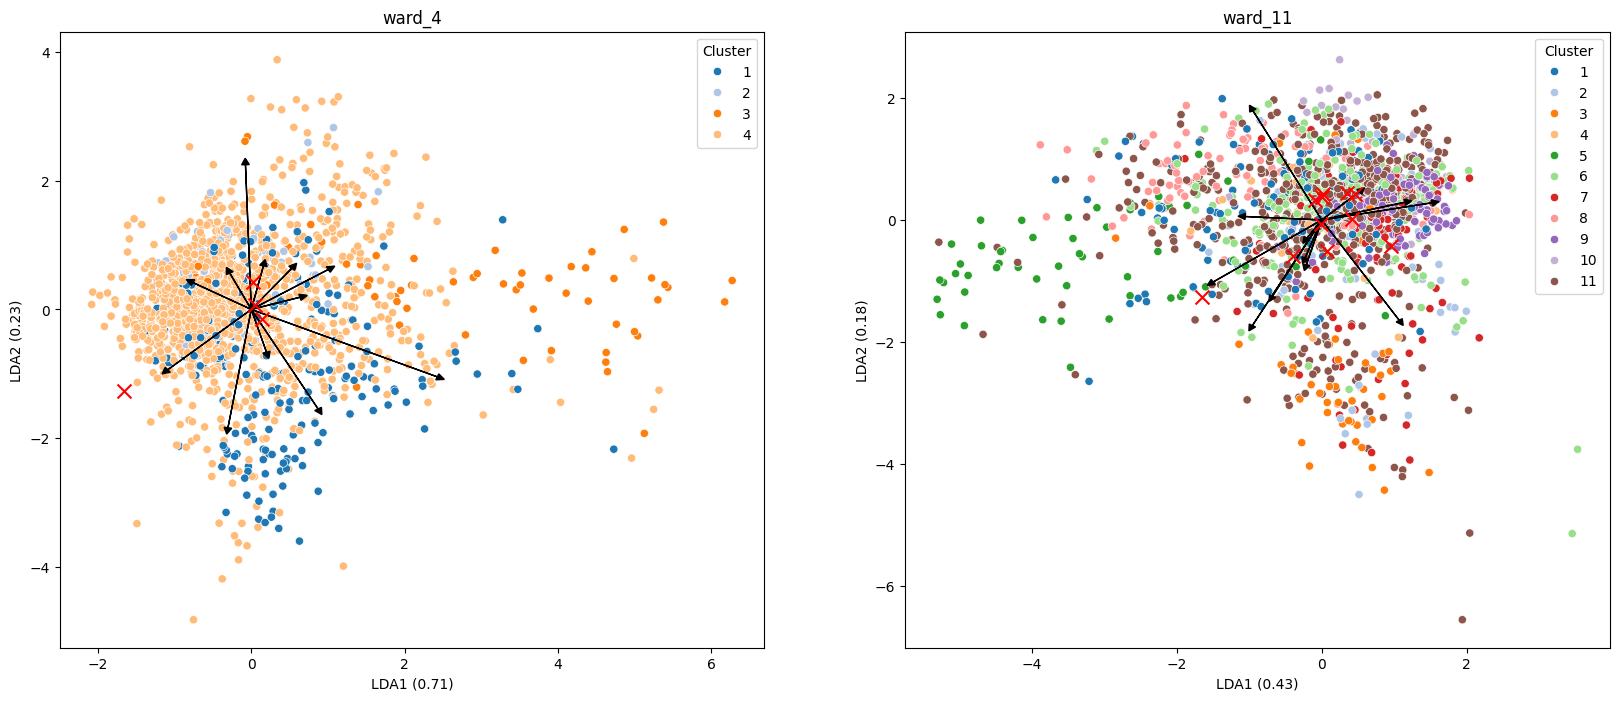

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs = axs.flatten()
for clustering, ax in zip(LDAs.keys(), axs):
    sns.scatterplot(
        x="LDA1",
        y="LDA2",
        hue="Cluster",
        data=projections[clustering],
        palette=sns.palettes.color_palette("tab20", n_colors=projections[clustering].Cluster.unique().size),
        ax=ax
    )
    for feature_scaling in LDAs[clustering].scalings_[:, :2]:
        ax.arrow(0, 0, 3 * feature_scaling[0], 3 * feature_scaling[1], head_width=0.1, head_length=0.1, fc='k', ec='k')
    
    for class_mean in LDAs[clustering].means_:
        ax.scatter(class_mean[0], class_mean[1], s=100, c="red", marker="x")

    ax.set_title(clustering)
    ax.set_xlabel(f"LDA1 ({LDAs[clustering].explained_variance_ratio_[0]:.2f})")
    ax.set_ylabel(f"LDA2 ({LDAs[clustering].explained_variance_ratio_[1]:.2f})")

In [73]:
training_data.to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Unknown_effect/training_data_LDA.csv")

In [64]:
np.linalg.norm(LDAs["ward_4"].scalings_, axis = 0)

array([1.07239569, 1.29250983, 1.34876543])

In [70]:
LDAs["ward_4"].means_

array([[ 0.14472852, -0.15625701,  0.04261264,  0.18553301,  0.21327621,
         0.23824857, -0.26988006, -0.01239301,  0.2396506 ,  0.35900194,
         0.15394252, -0.12242985],
       [ 0.02238332,  0.42695678, -0.11330921, -0.2384502 , -0.28571559,
        -0.53466609,  0.34993061, -0.33776311, -0.47857408, -0.13886702,
         0.10866722, -0.31170881],
       [-1.65552385, -1.2688235 ,  0.78835841,  1.07247408,  2.08014289,
         1.4664433 ,  1.50281473, -0.72084475,  1.2979465 , -0.44317799,
         0.31931792,  1.17037398],
       [ 0.05343425,  0.07179274, -0.04217924, -0.07838674, -0.13240696,
        -0.09229348, -0.0414222 ,  0.05810229, -0.08719932, -0.04220329,
        -0.05340928, -0.01701971]])